In [185]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import pickle

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, recall_score, balanced_accuracy_score, f1_score, precision_score
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures

from imblearn.over_sampling import SMOTE,RandomOverSampler
from imblearn.pipeline import make_pipeline

# About the Model

Random Forest Classifier is a complicated model than the Logistic Regression. It is an ensemble learning algorithm that combines multiple decision trees to make predictions. It operates by constructing a multitude of decision trees during training and outputs the class that is the mode of the classes predicted by individual trees. The features used in this model are similar to the logistic regression. We have categorical features such as the party of the governor and of the chambers. These columns will be one hot encoded. We also have text data as well. For this, we will need to use Count Vectorizer and Tfidf Vectorizer in order to plug them into the Logistic model.

CountVectorizer is a feature extraction technique used in natural language processing to convert text documents into numerical representations. It creates a matrix where each row corresponds to a document, and each column represents the frequency of a specific word in that document. TF-IDF Vectorizer stands for Term Frequency-Inverse Document Frequency Vectorizer. It is another feature extraction method used in NLP that assigns weights to each word in a document based on its frequency within the document and its rarity across all documents. The resulting matrix reflects the importance of each word in a document relative to the entire corpus. Both of these techniques are used in order to extract information through our modeling.

As our target variable is very imbalanced, oversampling techniques will be used to help our model recognize the unbalanced class. As with our last model, we will again use SMOTE, but we will find better results by changing a hyperparameter in the Random Forest Classifier called class weight. Changing this hyper parameter to 'balanced_subsample' will boost the importance of the smaller class making it easier for the model to recognize the bills passing class.

We used many combinations of mdoels and tuned the hyperarameters. Here is a summery of the results:

|Model|accuracy|recall|precision|
|---|---|---|---|
|rf|0.827260|0.427473|0.607971
|rf_hyperparams_overfit|0.836063|0.354762|0.689569
|rf_hyperparams_better|0.837778|0.293407|0.765409
|rf_hyperparams_sample_leaf|0.829460|0.212088|0.810924
|**rf_hyperparams_balanced_subsamples**|**0.725391**|**0.740293**|**0.404767**
|rf_SMOTE|0.759223|0.612637|0.435264
|smaller_df|0.765522|0.669839|0.483469

The best model was one with the balanced subsamples and other hyperparameters tuned. It is able to identify 75% of the passed bills in the test set and when it gets predicts it is going to be enacted, it is correct 40% of the time. This isn't the most impressive result but could be of some use to people interested in having a better idea wheter a bill will pass or not. 

|Model|accuracy|recall|precision|
|---|---|---|---|
abstracts|0.74913|0.752146|0.473809

This model using the abstracts does very well compared to the titles. This may be because there is more information in the abstracts. It is outside the scope of our problem statement though but shows promise for further study.

# Read In Data

In [64]:
df = pd.read_csv('../../Data/Merged_Data/final_data.csv.zip')
df_with_sponsors = pd.read_csv('../../Data/Merged_Data/final_data_with_sponsors.csv.zip')

# Splitting Data into Train and Test 

In [65]:
X = df[['title', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']]
y = df['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

# Metrics Function

In [66]:
def my_metrics(estimator, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test):
    
    train_preds = estimator.predict(X_train)
    preds = estimator.predict(X_test)
    
    train_acc = accuracy_score(y_train, train_preds)
    train_recall = recall_score(y_train, train_preds)
    test_acc = accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    
    print(f'Train Accuracy: {train_acc}')
    print(f'Train Recall: {train_recall}')
    print(f'Test Accuracy: {test_acc}')
    print(f'Test Recall: {recall}')
    print(f'Test Precision: {precision}')
    print()
    print(f'Test Confusion Matrix:')
    
    ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test)
    
    return {
        'accuracy': test_acc,
        'recall': recall,
        'precision': precision
    }


In [67]:
#List that will keep track of metrics
history = []

In [68]:
#For column transformers later
word_feature = 'title'
party_features = ['gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']

# Baseline Model

This model is one that guesses that the bill will not pass for every bill.

In [69]:
df['law_enacted'].value_counts(normalize = True)

0    0.796322
1    0.203678
Name: law_enacted, dtype: float64

This model has 79.6% accuracy

# CV with Simple with Default Random Forest
Strategy: First model will be kept simple:

    -CountVectorize title but only keep 200 features
    -OneHotEncode categorical variables
    -Random Forest

Train Accuracy: 0.9698970456580125
Train Recall: 0.8829131310664795
Test Accuracy: 0.8272595024059085
Test Recall: 0.42747252747252745
Test Precision: 0.6079708257358687

Test Confusion Matrix:


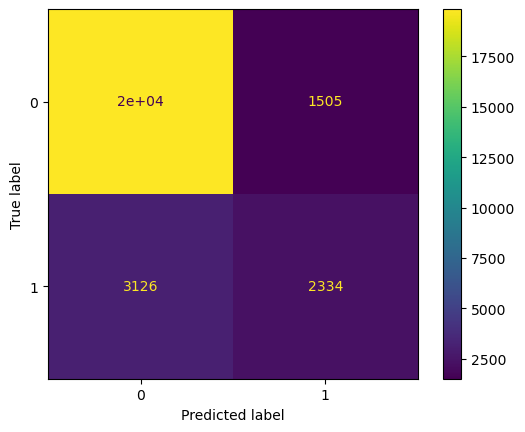

In [70]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', max_features=2000))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
rf_pipe = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestClassifier(random_state = 42))
])

rf_pipe.fit(X_train, y_train)

history.append(my_metrics(rf_pipe));

This model is definetly overfit. But shows much better promise than the Logistic Regression. The accuracy, recall and precision are all fairly high! Let's see if we can correct the overfitness with some hyperparameter tuning.

# CV with Random Forest and different hyperparameters

It would be better to just gridsearch cv over many hyper parameter combinations. But this will be too computationally expensive and thus I am manually going trhough the hyperparam combos.

## Max_Depth = 150 & n_estimator = 20
Strategy:

    -CountVectorize title and only keep the 2000 most used words
    -OneHotEncode categorical variables
    -Random Forest Classifier with some tuned parameters
        -Max_Depth = 150 & n_estimator = 20 :
            - the maximum depth of the tree and the amount of decision trees used in the forest
            - Hopefully these help with the overfitting seen above

Train Accuracy: 0.9316621903909281
Train Recall: 0.6824980159941395
Test Accuracy: 0.8360625163191465
Test Recall: 0.3547619047619048
Test Precision: 0.6895692417230331

Test Confusion Matrix:


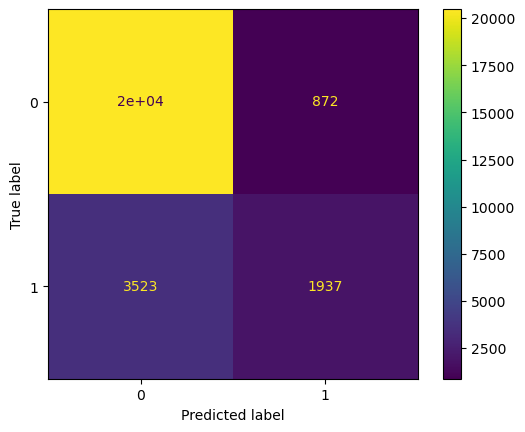

In [71]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', max_features=2000))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
rf_pipe_params1 = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestClassifier(random_state = 42, max_depth = 150,n_estimators = 20))
])

rf_pipe_params1.fit(X_train, y_train)

history.append(my_metrics(rf_pipe_params1));

In [72]:
pd.DataFrame(history, index = ['rf', 'rf_hyperparams_tuned'])

,accuracy,recall,precision
rf,0.827260,0.427473,0.607971
rf_hyperparams_tuned,0.836063,0.354762,0.689569


Better test accuracy, worse recall. Still overfit, more tuning needed.

## Max_Depth = 70 & n_estimator = 30
Strategy:

    -CountVectorize title and only keep the 2000 most used words
    -OneHotEncode categorical variables
    -Random Forest Classifier with some tuned parameters
        -Max_Depth = 70 & n_estimator = 30 :
            - Hopefully these help with the overfitting seen above

Train Accuracy: 0.8807072515666965
Train Recall: 0.42659178316342106
Test Accuracy: 0.8377783580140997
Test Recall: 0.2934065934065934
Test Precision: 0.7654085045389393

Test Confusion Matrix:


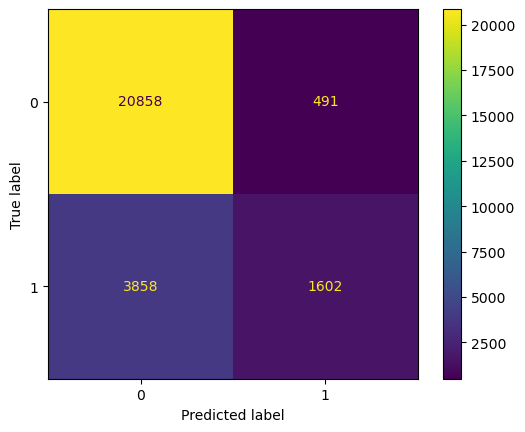

In [73]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', max_features=2000))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
rf_pipe_params2 = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestClassifier(random_state = 42, max_depth = 70,n_estimators = 30))
])

rf_pipe_params2.fit(X_train, y_train)

history.append(my_metrics(rf_pipe_params2));

In [74]:
pd.DataFrame(history, index = ['rf', 'rf_hyperparams_overfit', 'rf_hyperparams_better'])

,accuracy,recall,precision
rf,0.827260,0.427473,0.607971
rf_hyperparams_overfit,0.836063,0.354762,0.689569
rf_hyperparams_better,0.837778,0.293407,0.765409


Less overfit now, best accuracy yet, lowest recall though. Great precision. Very hard to predict the imbalance classes though.

## Max_Depth = 70 & n_estimator = 30 & min_samples_leaf = 7:
Strategy:

    -CountVectorize title and only keep the 2000 most used words
    -OneHotEncode categorical variables
    -Random Forest Classifier with some tuned parameters
        -Max_Depth = 70 & n_estimator = 30 & min_samples_leaf = 7:
            - min sample leaf refers to the minimum amount of samples required to be in a leaf node

Train Accuracy: 0.8306724360887298
Train Recall: 0.2066418411574385
Test Accuracy: 0.829460255884218
Test Recall: 0.21208791208791208
Test Precision: 0.8109243697478992

Test Confusion Matrix:


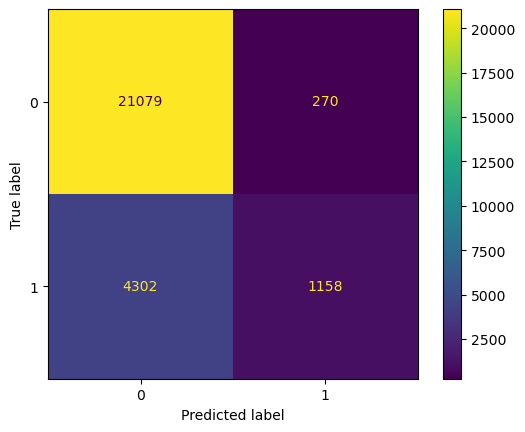

In [75]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', max_features=2000))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
rf_pipe_min_leaf = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestClassifier(random_state = 42, max_depth = 70,n_estimators = 30, min_samples_leaf = 7))
])

rf_pipe_min_leaf.fit(X_train, y_train)

history.append(my_metrics(rf_pipe_min_leaf));

In [76]:
pd.DataFrame(history, index = ['rf', 'rf_hyperparams_overfit', 'rf_hyperparams_better', 'rf_hyperparams_sample_leaf'])

,accuracy,recall,precision
rf,0.827260,0.427473,0.607971
rf_hyperparams_overfit,0.836063,0.354762,0.689569
rf_hyperparams_better,0.837778,0.293407,0.765409
rf_hyperparams_sample_leaf,0.829460,0.212088,0.810924


Sample leafs did not help.

## class_weight = 'balanced_subsample'
Strategy:

    -CountVectorize title and only keep the 1000 most used words
    -OneHotEncode categorical variables
    -Random Forest Classifier with some tuned parameters
        -Max_Depth = 70 & n_estimator = 30 & min_samples_leaf = 7, class_weight = 'balanced_subsample':
            - class_weight = 'balanced_subsample' gives a higher weight to the undersampled calss
            - hopefully will help with the imbalanced classes

Train Accuracy: 0.7443922212274943
Train Recall: 0.7859105060741103
Test Accuracy: 0.725390726994666
Test Recall: 0.7402930402930403
Test Precision: 0.40476667334267974

Test Confusion Matrix:


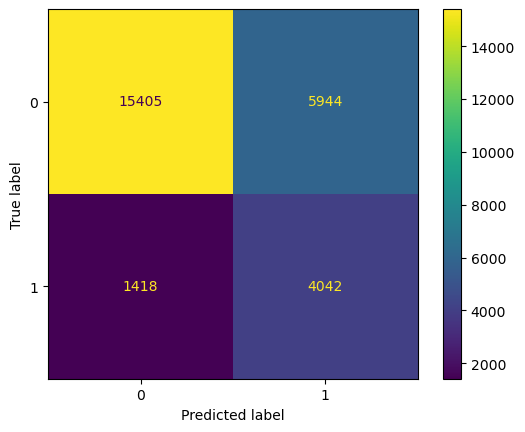

In [77]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', max_features=1000))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder())
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
rf_pipe_class_weight = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestClassifier(random_state = 42, max_depth = 70,n_estimators = 30, min_samples_leaf = 7, class_weight = 'balanced_subsample'))
])

rf_pipe_class_weight.fit(X_train, y_train)

history.append(my_metrics(rf_pipe_class_weight));

In [78]:
pd.DataFrame(history, index = ['rf', 'rf_hyperparams_overfit', 'rf_hyperparams_better', 'rf_hyperparams_sample_leaf', 'rf_hyperparams_balanced_subsamples'])

,accuracy,recall,precision
rf,0.827260,0.427473,0.607971
rf_hyperparams_overfit,0.836063,0.354762,0.689569
rf_hyperparams_better,0.837778,0.293407,0.765409
rf_hyperparams_sample_leaf,0.829460,0.212088,0.810924
rf_hyperparams_balanced_subsamples,0.725391,0.740293,0.404767


Great! Recall is through the roof! Accuracy is worse than our base model but we are able to identify 73% of the bills that pass. Only 40% of the ones we predict will pass actually do, but that is not too shaby.

# CV Random Forest with SMOTE

Train Accuracy: 0.7730403859544415
Train Recall: 0.6450155668152128
Test Accuracy: 0.7592226491103734
Test Recall: 0.6126373626373627
Test Precision: 0.435263500325309

Test Confusion Matrix:


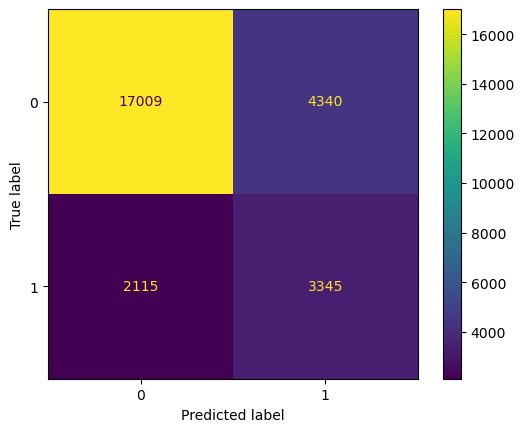

In [79]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', max_features=2000))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first'))
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
rf_pipe_smote = make_pipeline(
    preprocess, 
    SMOTE(random_state = 42),
    RandomForestClassifier(random_state = 42, max_depth = 70,n_estimators = 40, min_samples_leaf = 7)
)

rf_pipe_smote.fit(X_train, y_train)

history.append(my_metrics(rf_pipe_smote));

In [80]:
pd.DataFrame(history, index = ['rf', 'rf_hyperparams_overfit', 'rf_hyperparams_better', 
                               'rf_hyperparams_sample_leaf', 'rf_hyperparams_balanced_subsamples',
                              'rf_SMOTE'])

,accuracy,recall,precision
rf,0.827260,0.427473,0.607971
rf_hyperparams_overfit,0.836063,0.354762,0.689569
rf_hyperparams_better,0.837778,0.293407,0.765409
rf_hyperparams_sample_leaf,0.829460,0.212088,0.810924
rf_hyperparams_balanced_subsamples,0.725391,0.740293,0.404767
rf_SMOTE,0.759223,0.612637,0.435264


SMOTE did not improve on our best model.

# Model on smaller data with extra column

In [81]:
X = df_with_sponsors[['title', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber', 'majority_sponsor_party']]
y = df_with_sponsors['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)
#For column transformers later
word_feature = 'title'
party_features = ['gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber',  'majority_sponsor_party']

Train Accuracy: 0.7889963321107035
Train Recall: 0.7351512146752602
Test Accuracy: 0.7655218406135379
Test Recall: 0.6698393813206425
Test Precision: 0.4834693001288107

Test Confusion Matrix:


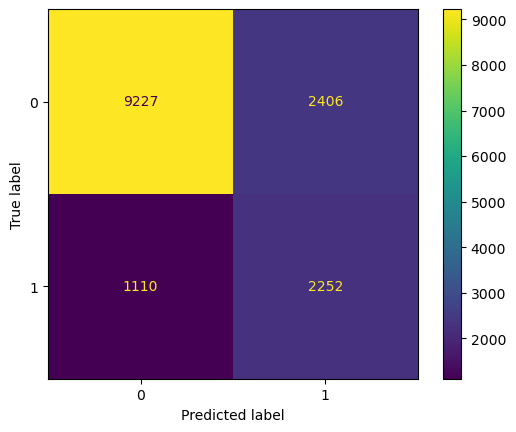

In [82]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', max_features=2000))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop= 'first')),
    ('poly', PolynomialFeatures())
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
rf_pipe_smaller_df = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestClassifier(random_state = 42, max_depth = 70,n_estimators = 40, min_samples_leaf = 7, class_weight = 'balanced_subsample'))
])

rf_pipe_smaller_df.fit(X_train, y_train)

history.append(my_metrics(rf_pipe_smaller_df, X_train, X_test, y_train, y_test));

In [83]:
pd.DataFrame(history, index = ['rf', 'rf_hyperparams_overfit', 'rf_hyperparams_better', 
                               'rf_hyperparams_sample_leaf', 'rf_hyperparams_balanced_subsamples',
                              'rf_SMOTE', 'smaller_df'])

,accuracy,recall,precision
rf,0.827260,0.427473,0.607971
rf_hyperparams_overfit,0.836063,0.354762,0.689569
rf_hyperparams_better,0.837778,0.293407,0.765409
rf_hyperparams_sample_leaf,0.829460,0.212088,0.810924
rf_hyperparams_balanced_subsamples,0.725391,0.740293,0.404767
rf_SMOTE,0.759223,0.612637,0.435264
smaller_df,0.765522,0.669839,0.483469


Worse recall than our model with more data points. The extra column did not improve the desired results.

# Using the bill's abstracts instead of the title

In [84]:
abstracts_df = df[df['abstract'].isnull() == False]

In [85]:
X = abstracts_df[['abstract', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']]
y = abstracts_df['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

word_feature = 'abstract'
party_features = ['gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']

In [86]:
abst = []

In [87]:
X_train.shape

(24142, 7)

In [88]:
X_test.shape

(8048, 7)

In [89]:
abstracts_df['law_enacted'].value_counts(normalize=True)

0    0.768437
1    0.231563
Name: law_enacted, dtype: float64

Train Accuracy: 0.7759092038770607
Train Recall: 0.809660107334526
Test Accuracy: 0.7491302186878728
Test Recall: 0.7521459227467812
Test Precision: 0.473808719161879

Test Confusion Matrix:


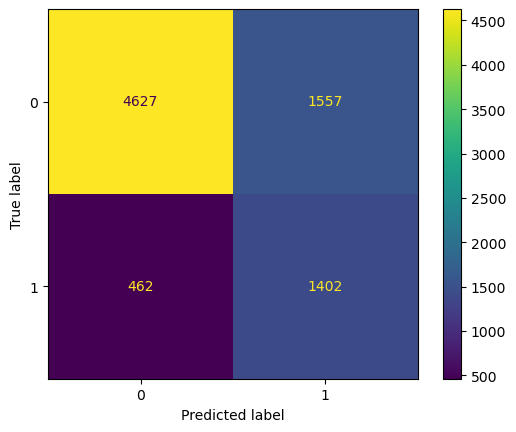

In [90]:
#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english'))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder())
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, word_feature),
    ('party', party_pipe, party_features)
])

#Estimator pipeline with our preprocessing in there
rf_pipe_class_weight = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestClassifier(random_state = 42, max_depth = 70,n_estimators = 40, min_samples_leaf = 7, class_weight = 'balanced_subsample'))
])

rf_pipe_class_weight.fit(X_train, y_train)

abst.append(my_metrics(rf_pipe_class_weight, X_train, X_test, y_train, y_test));

In [91]:
pd.DataFrame(abst)

,accuracy,recall,precision
0,0.74913,0.752146,0.473809


This is the best result yet! although this differes from our problem statement, using the bill abstracts yeilds the best results. Good to know for futer study.

# Saving info about our best model

## Saving Confusion Matrix

Train Accuracy: 0.7416567193872476
Train Recall: 0.7925035101642146
Test Accuracy: 0.7213622291021672
Test Recall: 0.7467032967032967
Test Precision: 0.40112160566706023

Test Confusion Matrix:


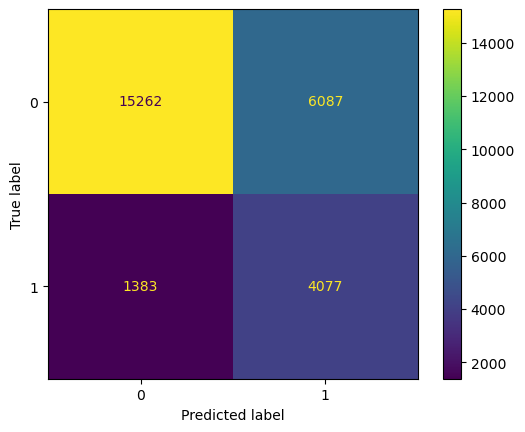

In [329]:
X = df[['title', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']]
y = df['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

#For column transformers later
word_feature = 'title'
party_features = ['gov_party','senate_party','house_party','state_party_control']

#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', max_features= 1000))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder())
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, 'title'),
    ('party', party_pipe, ['gov_party','senate_party','house_party','state_party_control'])
])

#Estimator pipeline with our preprocessing in there
rf_pipe_class_weight = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestClassifier(random_state = 42, max_depth = 70,n_estimators = 30, min_samples_leaf = 7, class_weight = 'balanced_subsample'))
])

rf_pipe_class_weight.fit(X_train, y_train)

(my_metrics(rf_pipe_class_weight));

In [222]:
15262/(15262+1383)

0.9169119855812556

In [219]:
cm = pd.DataFrame([[15262, 6087], [1383, 4077]], index = ['Bill Actually Failed', 'Bill Actually Passed'], columns = ['Model Predicts Fail', 'Model Predict Enacted'])

In [220]:
np.sum(np.sum(cm))

26809

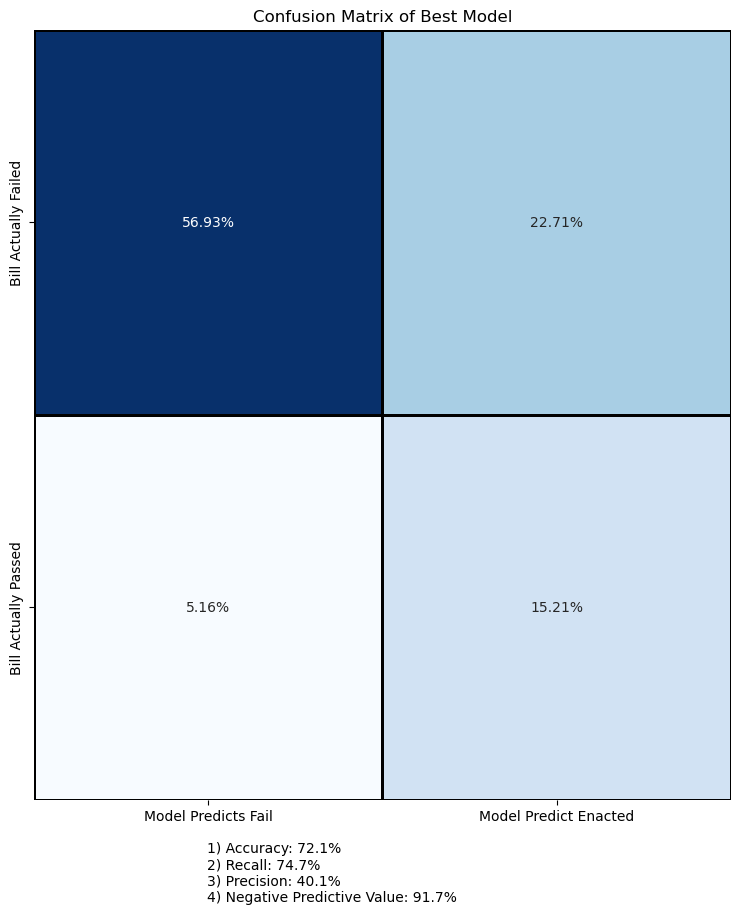

In [336]:
plt.figure(figsize = (9,10))
sns.heatmap(cm/np.sum(np.sum(cm)), 
            annot = True, 
            fmt='.2%', 
            cmap='Blues', 
            robust = True, 
            cbar = False,
            linewidths = 1,
            linecolor = 'black',
           )

plt.annotate('''1) Accuracy: 72.1%
2) Recall: 74.7%
3) Precision: 40.1%
4) Negative Predictive Value: 91.7%''', 
             (0,0), (125, -30), xycoords='axes fraction', textcoords='offset points', va='top') 
plt.title('Confusion Matrix of Best Model')

plt.savefig(f'confusion_matrix.png');

## Pickling model for streamlit app

In [331]:
X = df[['title', 'gov_party','senate_party','house_party','state_party_control','party_of_1st_chamber','party_of_2nd_chamber']]
y = df['law_enacted']


X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, stratify = y)

#For column transformers later
word_feature = 'title'
party_features = ['gov_party','senate_party','house_party','state_party_control']

#Pipeline for our title feature: Count Vectorize it
word_pipe = Pipeline([
    ('cv', CountVectorizer(stop_words='english', max_features= 10000))
])

#Pipeline for the party features: One Hot encode them
party_pipe = Pipeline([
    ('ohe', OneHotEncoder())
])

#Column transformer that will transform our whole dataframe
preprocess = ColumnTransformer([
    ('cvec', word_pipe, 'title'),
    ('party', party_pipe, ['gov_party','senate_party','house_party','state_party_control'])
])

#Estimator pipeline with our preprocessing in there
rf_pipe_class_weight = Pipeline([
    ('pre', preprocess),
    ('rf', RandomForestClassifier(random_state = 42, max_depth = 70,n_estimators = 30, min_samples_leaf = 7, class_weight = 'balanced_subsample'))
])

rf_pipe_class_weight.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('cvec',
                                                  Pipeline(steps=[('cv',
                                                                   CountVectorizer(max_features=10000,
                                                                                   stop_words='english'))]),
                                                  'title'),
                                                 ('party',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['gov_party', 'senate_party',
                                                   'house_party',
                                                   'state_party_control'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced_subsample',
                              

In [332]:
with open('random_forest.pkl', 'wb') as pickle_out:
    pickle_out = pickle.dump(rf_pipe_class_weight, pickle_out)